In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('C:/Users/Damien/Desktop/Aquis/Resources/creditcardfraud_normalised.csv')

In [3]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,class
0,0.935192,0.766490,0.881365,0.313023,0.763439,0.267669,0.266815,0.786444,0.475312,0.510600,...,0.561184,0.522992,0.663793,0.391253,0.585122,0.394557,0.418976,0.312697,0.005824,0
1,0.978542,0.770067,0.840298,0.271796,0.766120,0.262192,0.264875,0.786298,0.453981,0.505267,...,0.557840,0.480237,0.666938,0.336440,0.587290,0.446013,0.416345,0.313423,0.000105,0
2,0.935217,0.753118,0.868141,0.268766,0.762329,0.281122,0.270177,0.788042,0.410603,0.513018,...,0.565477,0.546030,0.678939,0.289354,0.559515,0.402727,0.415489,0.311911,0.014739,0
3,0.941878,0.765304,0.868484,0.213661,0.765647,0.275559,0.266803,0.789434,0.414999,0.507585,...,0.559734,0.510277,0.662607,0.223826,0.614245,0.389197,0.417669,0.314371,0.004807,0
4,0.938617,0.776520,0.864251,0.269796,0.762975,0.263984,0.268968,0.782484,0.490950,0.524303,...,0.561327,0.547271,0.663392,0.401270,0.566343,0.507497,0.420561,0.317490,0.002724,0


In [4]:
X = df.drop(columns=['class'])
Y = df['class']

## PCA

In [5]:
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
def PCA_2(data):
    min_max_scaler = preprocessing.StandardScaler()
    np_scaled = min_max_scaler.fit_transform(data)
    data = pd.DataFrame(np_scaled)
    # reduce to 2 importants features
    pca = PCA(n_components=2)
    data = pca.fit_transform(data)
    # standardize these 2 new features
    min_max_scaler = preprocessing.StandardScaler()
    np_scaled = min_max_scaler.fit_transform(data)
    data = pd.DataFrame(np_scaled)
    return data

## K-means

In [8]:
def KmeansCluster(data):
    n_cluster = range(1, 20)
    kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
    scores = [kmeans[i].score(data) for i in range(len(kmeans))]
    return kmeans, scores

In [9]:
def plot_elbow(scores, title):
    n_cluster = range(1,20)
    sns.lineplot(x=n_cluster, y=scores)
    sns.set_style("darkgrid")
    plt.xlabel('Number of Clusters')
    plt.ylabel('Kmeans Score')
    plt.title(str(title) + " Elbow Visual")
    return plt.show()

In [43]:
data = PCA_2(X)

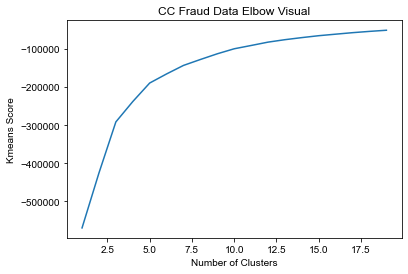

In [11]:
kmeans, scores = KmeansCluster(data)
plot_elbow(scores, title = 'CC Fraud Data')

In [12]:
def assign_clusters(df, data, kmeans, cluster):
    df['Cluster'] = kmeans[cluster].predict(data)
    df['Principal_1'] = data[0]
    df['Principal_2'] = data[1]
    return df

In [13]:
def plotClusters(df, title):
    sns.scatterplot(x='Principal_1',
                    y='Principal_2',
                    data=df,
                    hue='Cluster',
                    palette="deep"
                   )
    plt.xlabel('Principal Feature 1')
    plt.ylabel('Principal Feature 2')
    plt.title(str(title) + ' Visual of the Clusters')
    return plt.show()

In [14]:
def getDistanceByPoint(data, model):
    distance = []
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.append(np.linalg.norm(Xa-Xb))
        
    distance = pd.Series(distance)
    return distance

In [15]:
def assignKmeansAnamoly(df, data, kmeans, cluster, outliers_fraction):
    distance = getDistanceByPoint(data, kmeans[cluster])
    number_of_outliers = int(outliers_fraction*len(distance))
    threshold = distance.nlargest(number_of_outliers).min()
    df['Anomaly_Kmeans'] = (distance >= threshold).astype(int)
    return df

In [16]:
def PlotClusterAnomaly(df, title):
    sns.scatterplot(x='Principal_1',
                    y='Principal_2',
                    data=df,
                    hue="Anomaly_Kmeans",
                    palette="deep")
    plt.xlabel('Principal Feature 1')
    plt.ylabel('Principal Feature 2')
    plt.title(str(title) + ' Visual of the Clusters with Anomaly')
    plt.legend([],[], frameon=False)
    return plt.show()

In [17]:
def PlotKmeansAnamoly(df, title):
    a = df.loc[df['Anomaly_Kmeans'] == 1, ['timestamp', 'value']]

    fig, ax = plt.subplots()

    a = df.loc[df['Anomaly_Kmeans'] == 1, ['timestamp', 'value']] #anomaly

    ax.plot(df['timestamp'],
            df['value'],
            color='blue')
    ax.scatter(a['timestamp'],
               a['value'],
               color='red')
    plt.xlabel('Date')
    plt.setp(ax.get_xticklabels(), rotation=45)
    plt.title(str(title) + ' with K-Means Anomaly detection \n (Threhold = 0.001)')
    return plt.show()

In [40]:
def plot_confusion(TN, FP, FN, TP, title):
    confusion_mat = [[TN, FN], [FP, TP]]
    ax = sns.heatmap(confusion_mat, annot=True, fmt='d', cmap="YlGnBu", cbar=False)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title("Confusion Matrix \n" + title)
    ax.set_xticklabels(['No Fraud', 'Fraud'])
    ax.set_yticklabels(['No Fraud', 'Fraud'])
    return plt.show()

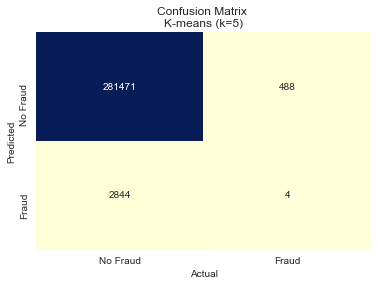

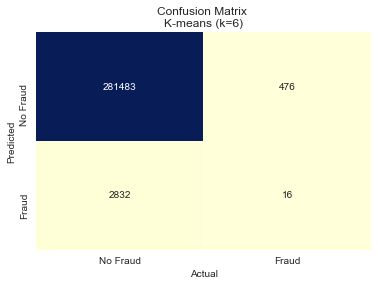

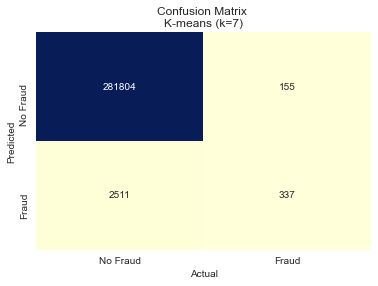

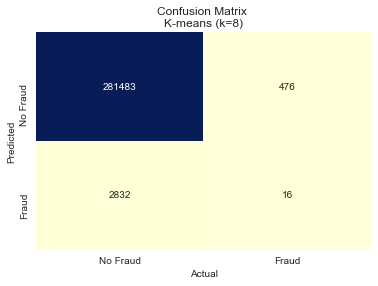

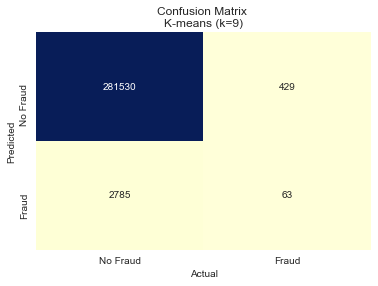

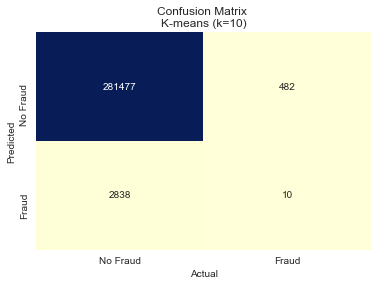

In [44]:
clusters = list(range(5,11))
outlier_fraction=0.01
for cluster in clusters:
    df = assign_clusters(df, data, kmeans, cluster)
    df = assignKmeansAnamoly(df, data, kmeans, cluster, outlier_fraction)
    TP = df[(df['class'] == 1) & (df['Anomaly_Kmeans'] == 1)].shape[0]
    TN = df[(df['class'] == 0) & (df['Anomaly_Kmeans'] == 0)].shape[0]
    FP = df[(df['class'] == 0) & (df['Anomaly_Kmeans'] == 1)].shape[0]
    FN = df[(df['class'] == 1) & (df['Anomaly_Kmeans'] == 0)].shape[0]
    plot_confusion(TN,FP,FN,TP, title='K-means (k=' + str(cluster) + ')')

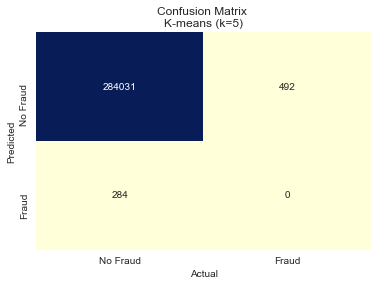

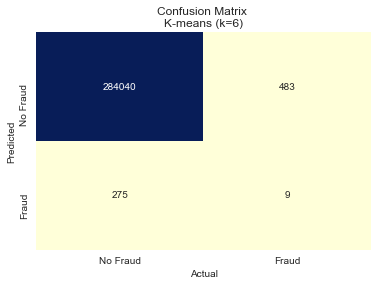

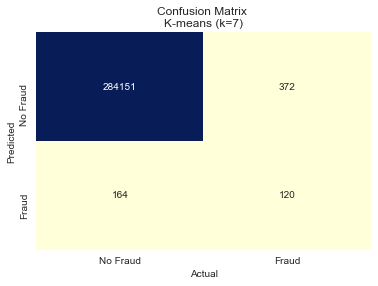

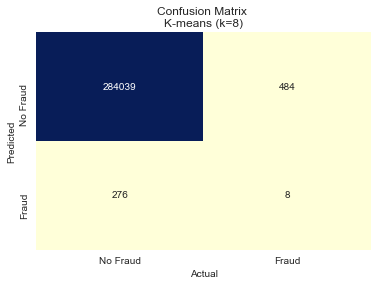

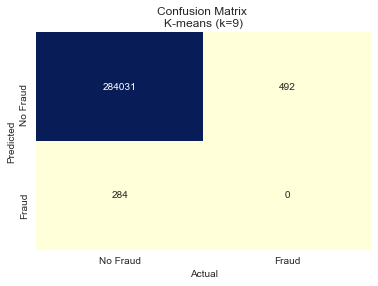

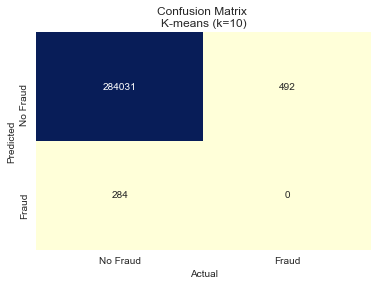

In [45]:
outlier_fraction=0.001
for cluster in clusters:
    df = assign_clusters(df, data, kmeans, cluster)
    df = assignKmeansAnamoly(df, data, kmeans, cluster, outlier_fraction)
    TP = df[(df['class'] == 1) & (df['Anomaly_Kmeans'] == 1)].shape[0]
    TN = df[(df['class'] == 0) & (df['Anomaly_Kmeans'] == 0)].shape[0]
    FP = df[(df['class'] == 0) & (df['Anomaly_Kmeans'] == 1)].shape[0]
    FN = df[(df['class'] == 1) & (df['Anomaly_Kmeans'] == 0)].shape[0]
    plot_confusion(TN,FP,FN,TP, title='K-means (k=' + str(cluster) + ')')

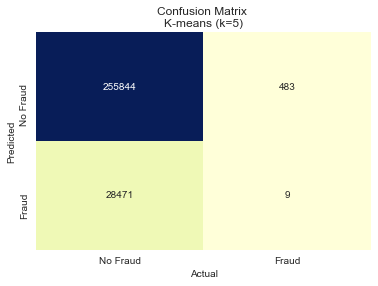

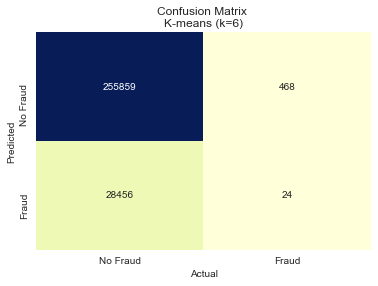

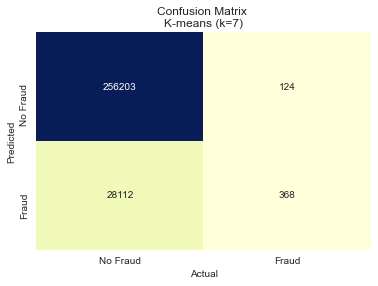

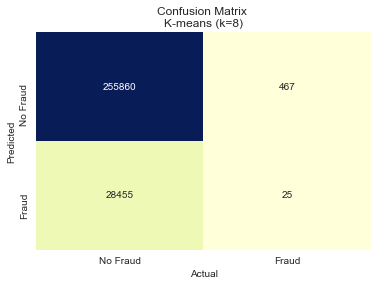

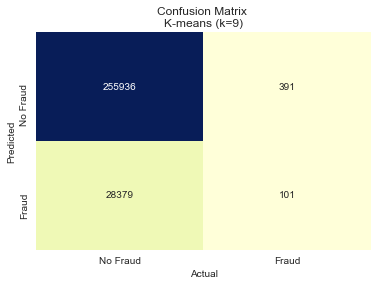

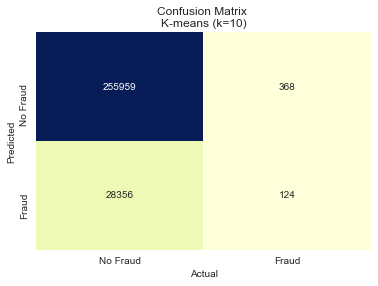

In [46]:
outlier_fraction=0.1
for cluster in clusters:
    df = assign_clusters(df, data, kmeans, cluster)
    df = assignKmeansAnamoly(df, data, kmeans, cluster, outlier_fraction)
    TP = df[(df['class'] == 1) & (df['Anomaly_Kmeans'] == 1)].shape[0]
    TN = df[(df['class'] == 0) & (df['Anomaly_Kmeans'] == 0)].shape[0]
    FP = df[(df['class'] == 0) & (df['Anomaly_Kmeans'] == 1)].shape[0]
    FN = df[(df['class'] == 1) & (df['Anomaly_Kmeans'] == 0)].shape[0]
    plot_confusion(TN,FP,FN,TP, title='K-means (k=' + str(cluster) + ')')

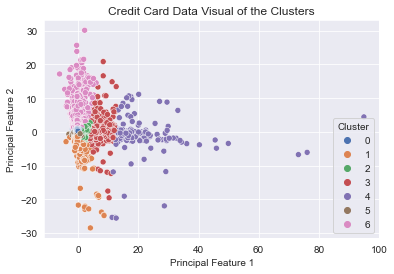

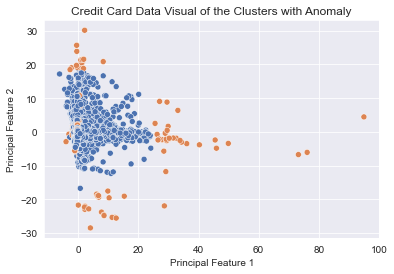

In [54]:
cluster = 6
outliers_fraction = 0.1
data = PCA_2(X)
df = assign_clusters(df, data, kmeans, cluster)
df = assignKmeansAnamoly(df, data, kmeans, cluster, outliers_fraction)
plotClusters(df, title = "Credit Card Data")
PlotClusterAnomaly(df, title = "Credit Card Data")

## Isolation Forest

In [47]:
from sklearn.ensemble import IsolationForest
# Take useful feature and standardize them 
def isolationForest(df, data, outliers_fraction):
    min_max_scaler = preprocessing.StandardScaler()
    np_scaled = min_max_scaler.fit_transform(data)
    data = pd.DataFrame(np_scaled)
    # train isolation forest 
    model =  IsolationForest(contamination = outliers_fraction)
    model.fit(data)
    # add the data to the main  
    df['Anomaly_IF'] = pd.Series(model.predict(data))
    df['Anomaly_IF'] = df['Anomaly_IF'].map( {1: 0, -1: 1} )
    return df

In [48]:
def plotIsolationForest(df, title):
    fig, ax = plt.subplots()

    a = df.loc[df['Anomaly_IF'] == 1, ['timestamp', 'value']] #anomaly

    ax.plot(df['timestamp'], df['value'], color='blue')
    ax.scatter(a['timestamp'],a['value'], color='red')
    plt.xlabel('Date')
    plt.setp(ax.get_xticklabels(), rotation=45)
    plt.title(str(title) + ' with Isolation Forest detection \n (Threhold = 0.001)')
    return plt.show()

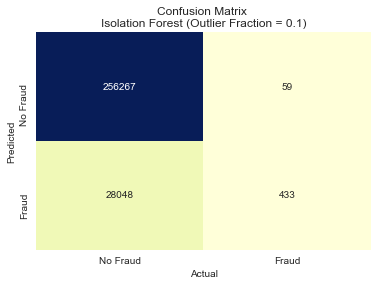

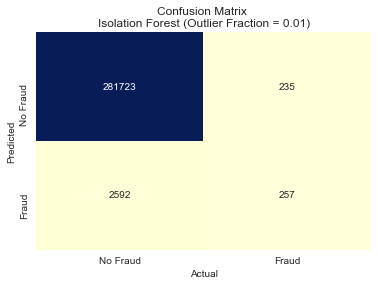

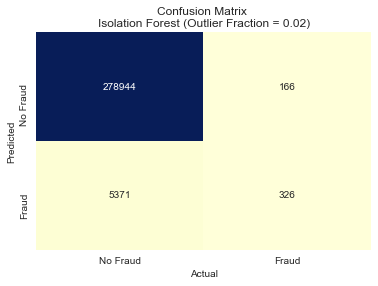

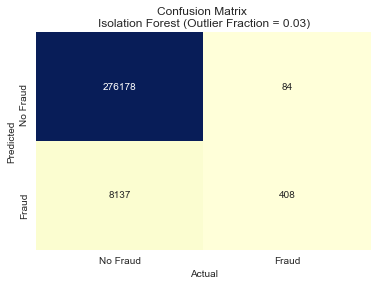

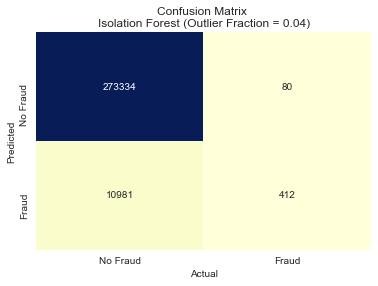

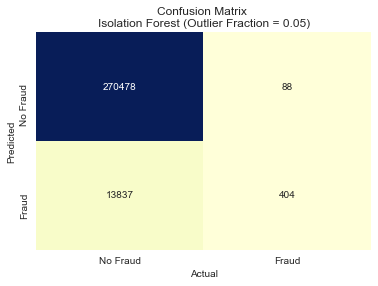

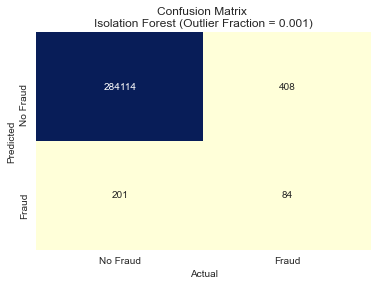

In [49]:
outliers_fractions= [0.1, 0.01, 0.02, 0.03, 0.04, 0.05, 0.001]
data = X
for outliers_fraction in outliers_fractions:
    df = isolationForest(df, data, outliers_fraction)
    TP = df[(df['class'] == 1) & (df['Anomaly_IF'] == 1)].shape[0]
    TN = df[(df['class'] == 0) & (df['Anomaly_IF'] == 0)].shape[0]
    FP = df[(df['class'] == 0) & (df['Anomaly_IF'] == 1)].shape[0]
    FN = df[(df['class'] == 1) & (df['Anomaly_IF'] == 0)].shape[0]
    plot_confusion(TN,FP,FN,TP, 
                   title='Isolation Forest (Outlier Fraction = ' + str(outliers_fraction) +')'
                  )


## SVM

In [50]:
from sklearn.svm import OneClassSVM

def SVM(df, data, outliers_fraction):
    min_max_scaler = preprocessing.StandardScaler()
    np_scaled = min_max_scaler.fit_transform(data)
    # train one class SVM 
    model =  OneClassSVM(nu=0.95 * outliers_fraction)
    data = pd.DataFrame(np_scaled)
    model.fit(data)
    # add the data to the main  
    df['Anomaly_SVM'] = pd.Series(model.predict(data))
    df['Anomaly_SVM'] = df['Anomaly_SVM'].map( {1: 0, -1: 1} )
    return df

In [51]:
def plotSVM(df, title):
    fig, ax = plt.subplots()

    a = df.loc[df['Anomaly_SVM'] == 1, ['timestamp', 'value']] #anomaly

    ax.plot(df['timestamp'], df['value'], color='blue')
    ax.scatter(a['timestamp'],a['value'], color='red')
    plt.xlabel('Date')
    plt.setp(ax.get_xticklabels(), rotation=45)
    plt.title(str(title) + ' with SVM detection \n (Threhold = 0.001)')
    plt.show()

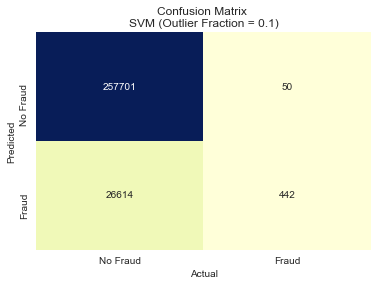

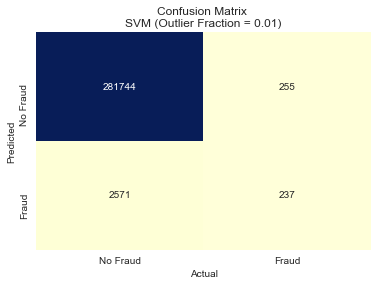

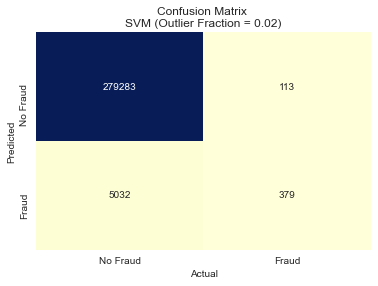

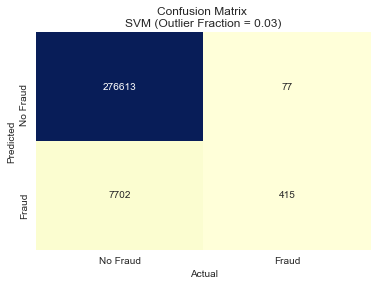

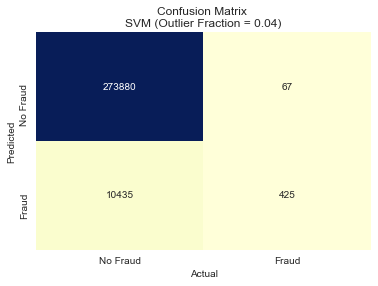

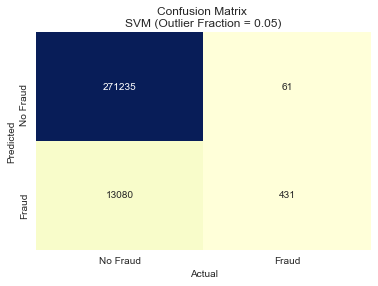

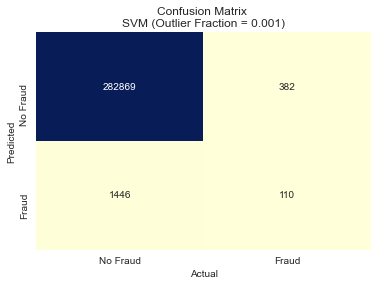

In [52]:
outliers_fractions= [0.1, 0.01, 0.02, 0.03, 0.04, 0.05, 0.001]
data = X

for outliers_fraction in outliers_fractions:
    df = SVM(df, data, outliers_fraction)
    TP = df[(df['class'] == 1) & (df['Anomaly_SVM'] == 1)].shape[0]
    TN = df[(df['class'] == 0) & (df['Anomaly_SVM'] == 0)].shape[0]
    FP = df[(df['class'] == 0) & (df['Anomaly_SVM'] == 1)].shape[0]
    FN = df[(df['class'] == 1) & (df['Anomaly_SVM'] == 0)].shape[0]
    plot_confusion(TN,FP,FN,TP, 
                   title='SVM (Outlier Fraction = ' + str(outliers_fraction) +')'
                  )